In [ ]:
print('Full name: ' + ' Mohammad Nourbakhsh Marvast')
print('STD ID: ' + '401200482')

Full name:  Mohammad Nourbakhsh Marvast
STD ID: 401200482


# Import Necessary Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Greedy Policy:

In [ ]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])
  return action

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  action = np.argmax(Qtable[state])
  random_int = random.uniform(0,1)

  ## action = 0: go rightward
  ## action = 1: go up

  if random_int < epsilon:
    action = 1 - action

  return action

#Transition between our $N \times N$ grid and the state vector having lenght $N^2$:

In [ ]:
def state_to_coordinate(state, column):
  #print(f'*********** {state}, {type(state)} **********')
  i = int(state/column)
  j = state%column

  return i,j

In [ ]:
def coordinate_to_state(coordinate, column):
  state = column * coordinate[0] + coordinate[1]
  return state

Determining the next state according to our current state the action we want to use (going right or going up!):

In [ ]:
def next_state(current_state, action, row, column):
  i, j = state_to_coordinate(current_state, column)
  if action == 0 and j < column - 1:
    return (current_state + 1)
    # or
    # return (coordinate_to_state((i,j+1), column))
  elif action == 1 and i != 0:
    return (coordinate_to_state((i-1,j), column))

  elif (action == 0 and j == column - 1 and i != 0) or (action == 1 and j != column - 1 and i == 0):
    return(next_state(current_state, 1-action, row, column))

  else:
    print(f'************ oppsssss + {current_state, i, j} ************')
    return (current_state)

How much reward we recieve in going from the current state to the next state according to the action:

In [ ]:
def reward_in_action(rewards_matrix, current_state, action):
  row, column = rewards_matrix.shape
  s_next = next_state(current_state, action, row, column)

  i,j = state_to_coordinate(s_next, column)

  return rewards_matrix[i,j]

#Updating our Q-table:

Q-table: the table consisting of our states and actions

In [ ]:
def update_Qtable(Qtable, rewards_matrix,
                  total_episodes = 18000, learning_rate = 0.9, max_steps = 90, gamma = 1,
                  epsilon = 1.0, max_epsilon = 1.0, min_epsilon = 0.001, decay_rate = 0.005):

  ## total_episodes                # Total episodes
  ## learning_rate                 # Learning rate
  ## max_steps                     # Max steps per episode
  ## gamma                         # Discounting rate

  # Exploration parameters
  ## epsilon                       # Exploration rate
  ## max_epsilon                   # Exploration probability at start
  ## min_epsilon                   # Minimum exploration probability
  ## decay_rate                    # Exponential decay rate for exploration prob

  ## action = 0: go rightward
  ## action = 1: go up

  # List of rewards
  rewards = []

  row, column = rewards_matrix.shape

  # Until learning is stopped
  for episode in range(total_episodes):
      # Reset
      current_state = column * (row -1)
      step = 0
      total_rewards = rewards_matrix[-1,0]

      for step in range(row + column -2):
          if current_state == column -1:
            break
          # Choose an action a in the current world state (s)
          action = epsilon_greedy_policy(Qtable, current_state, epsilon)

          # Take the action (a) and observe the outcome state(s') and reward (r)
          new_state = next_state(current_state, action, row, column)

          reward = reward_in_action(rewards_matrix, current_state, action)

          # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
          # qtable[new_state,:] : all the actions we can take from new state
          Qtable[current_state, action] = Qtable[current_state, action] + learning_rate * (reward + gamma * np.max(Qtable[new_state, :]) - Qtable[current_state, action])

          total_rewards += reward

          # Our new state is state
          current_state = new_state

      # Reduce epsilon (because we need less and less exploration)
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
      rewards.append(total_rewards)

  #print ("Score over time: " +  str(sum(rewards)/total_episodes))
  return Qtable, rewards

# Finding Optimal Route

Using our Q-table to decide which way we should chose to go:

In [ ]:
def play(rewards_matrix, Qtable):

  total_reward = rewards_matrix[-1,0]
  road = np.empty(rewards_matrix.shape)
  road[:]= np.nan

  row, column = rewards_matrix.shape
  road[0,column-1] = rewards_matrix[0,column-1]
  state = column * (row -1)
  step = 0

  for step in range(row + column -2):
    i, j = state_to_coordinate(state, column)
    road[i,j] = rewards_matrix[i,j]

    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state,:])

    new_state = next_state(state, action, row, column)

    reward = reward_in_action(rewards_matrix, state, action)

    total_reward += reward

    state = new_state


  return road, total_reward


#Plots

In [ ]:
def plot_optimal_road(grid, optimal_road, optimal_value, show_values= False, color= 'darkblue'):
  grid = np.array(grid)
  optimal_road = np.array(optimal_road)
  fig, ax = plt.subplots(figsize=(12,10))
  ax.clear()

  plt.title(f'The Grid and The Optimal Route\nTotal Reward: {optimal_value}')

  # Plotting initial heatmap
  im = ax.imshow(grid, cmap = "Blues")

  row, column = grid.shape

  ax.axis('off')

  # Add the color bar
  cbar = ax.figure.colorbar(im, ax = ax)
  cbar.ax.set_ylabel("Rewards", rotation = -90, va = "bottom")

  # Plotting optimal road
  non_nan_indices = np.where(np.logical_not(np.isnan(optimal_road)))
  x = non_nan_indices[1]
  y = non_nan_indices[0]

  for i in range(len(x)):
    ax.add_patch(plt.Rectangle((x[i] - .5, y[i] - .5), 1, 1, fill=False, edgecolor= color, lw=3))



  # Loop over data dimensions and create text annotations
  if show_values:
    for i in range(row):
        for j in range(column):
            text = ax.text(j, i, grid[i, j],
                          ha="center", va="center", color="w")
  plt.show()
  return im

In [ ]:
def plot_dynamics(rewards, epsilon= 1):

  total_episodes = len(rewards)

  fig, ax = plt.subplots(figsize=(12,4))
  ax.clear()
  ax.plot(range(total_episodes), rewards)

  R = rewards[5000:]
  r = max(R,key=R.count)

  ax.axhline(y=r, color='r', linestyle=':')

  #trans = transforms.blended_transform_factory(
  #ax.get_yticklabels()[0].get_transform(), ax.transData)
  #ax.text(0,rewards[s], "{:.0f}".format(rewards[s]), color="red", transform=trans, ha="right", va="center")

  plt.title('Rewards vs Num of Episodes')
  ax.set_ylim((np.min(rewards)-50,rewards[-1]+50))
  ax.set_xlim((-1,total_episodes+1))
  #plt.legend()

  yticks = ax.set_yticks([int(np.min(rewards)/100)*100,0, r])
  ax.set_xlabel('number of episodes')
  ax.set_ylabel('reward')

  #ax.axis('off')

  return ax

In [ ]:
def plot_learning_rate(grid, total_episodes= 8000):
  R = []
  n=15
  for decay_rate in np.linspace(0,.01,n):
    _, rewards = optimal_road(grid,
                              printt= False, xlsx= False, qtable_xlsx = False,
                              total_episodes = total_episodes, learning_rate = 0.4,
                              max_steps = 99, gamma = .5,
                              epsilon = 1.0, max_epsilon = 1.0,
                              min_epsilon = 0.01, decay_rate = decay_rate)

    R.append(rewards[-1])

  plt.bar(np.linspace(0,.01,n), R)

# Optimal Route

In [ ]:
def optimal_road(rewards_matrix,
                 printt= True, xlsx= False, qtable_xlsx = False,
                 total_episodes = 10000, learning_rate = 0.8, max_steps = 99, gamma = 0.95,
                 epsilon = 1.0, max_epsilon = 1.0, min_epsilon = 0.01, decay_rate = 0.0005):

  rewards_matrix = np.array(rewards_matrix)
  row , column = rewards_matrix.shape

  Qtable = np.zeros(shape= (row * column, 2))

  Qtable, rewards = update_Qtable(Qtable, rewards_matrix,
                                  total_episodes= total_episodes, learning_rate= learning_rate,
                                  max_steps= max_steps, gamma= gamma,
                                  epsilon= epsilon, max_epsilon= max_epsilon,
                                  min_epsilon= min_epsilon, decay_rate= decay_rate)
  if qtable_xlsx == True:
    pd.DataFrame(Qtable, columns= None).to_excel("qtable.xlsx")


  road, max_road_reward = play(rewards_matrix, Qtable)
  road = pd.DataFrame(road, columns= None)


  ## Saving result:
  if printt and xlsx:
    road.to_excel("opt_road.xlsx")
    print(f'The maximum reward: \n{max_road_reward}')
    print('The optimal road is depicted in the file nemed "opt_road.xlsx"! ')
  elif printt and not xlsx:
    print(f'The maximum reward: \n{max_road_reward}')

  return road, rewards, max_road_reward

#Loading Main Data:

In [ ]:
data =  pd.read_excel('Grid.xlsx', header = None)
grid = np.array(data)

In [ ]:
## You can see the optimal road in the file 'opt_road.xlsx'!
## In case you want to see the updated Q-table, make 'qtable_xlsx' True!

road, rewards, max_road_reward = optimal_road(grid,
                                              xlsx= False, qtable_xlsx = False,
                                              total_episodes = 8000, learning_rate = 0.8,
                                              max_steps = 99, gamma = 0.95,
                                              epsilon = 1.0, max_epsilon = 1.0,
                                              min_epsilon = 0.01, decay_rate = 0.001)

The maximum reward: 
385


<Axes: title={'center': 'Rewards vs Num of Episodes'}, xlabel='number of episodes', ylabel='reward'>

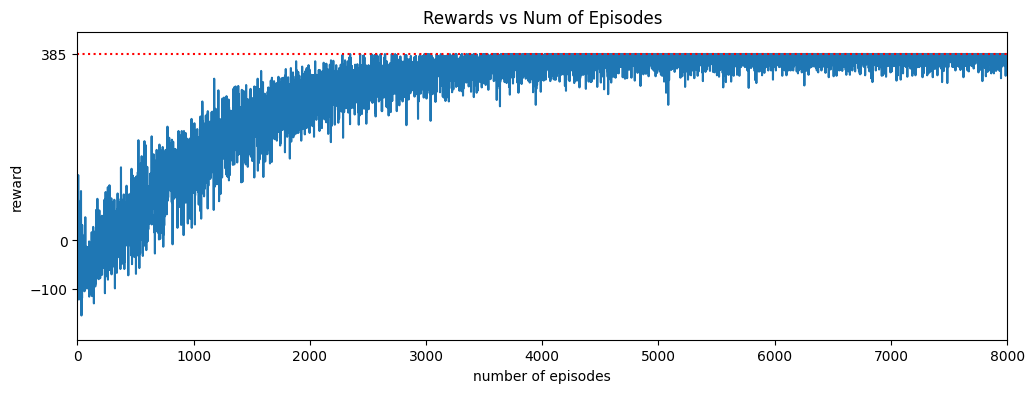

In [ ]:
plot_dynamics(rewards)

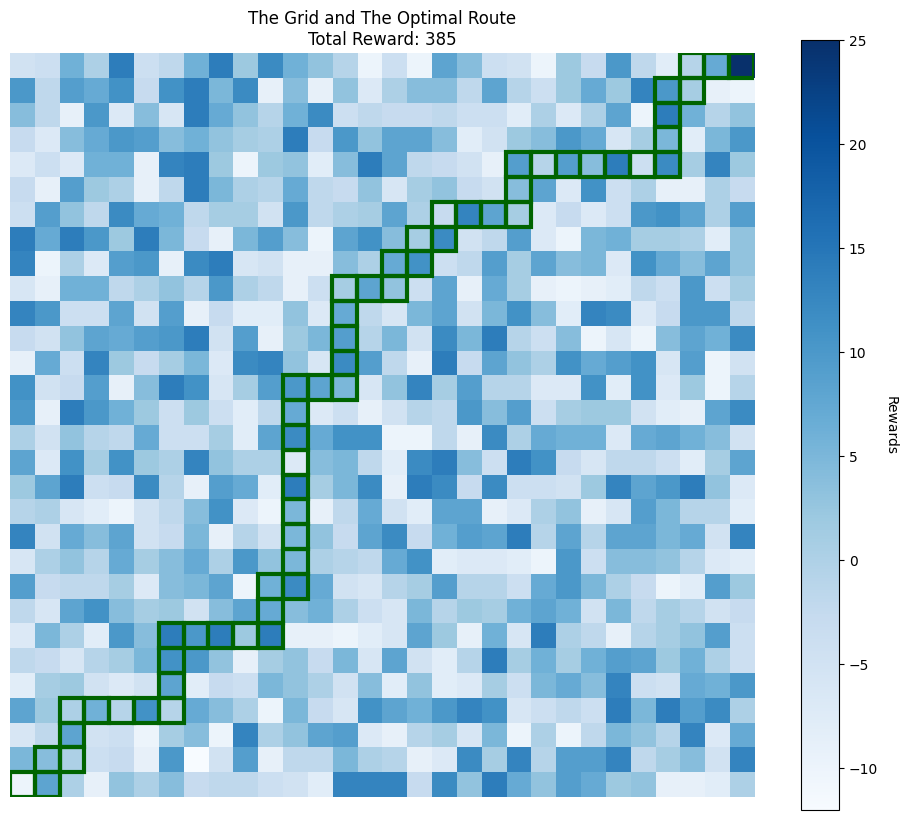

In [ ]:
plot_optimal_road(grid, optimal_road= road, optimal_value= max_road_reward, show_values= False, color = 'darkgreen')

#Loading Fack Data:

In [ ]:
##fack data set
n = 3
m = 5
M = np.random.normal(0, 20, size=(n, m))
pd.DataFrame(M)

,0,1,2,3,4
0,-16.898860,-3.327508,-3.650572,52.936149,5.158467
1,-16.748187,9.035939,38.529353,-19.959794,-12.762371
2,-15.706725,8.832865,15.981168,-13.734318,11.386504


In [ ]:
fack_road, fack_rewards, max_road_reward = optimal_road(M, xlsx= False)
fack_road

The maximum reward: 
102.08070542120211


,0,1,2,3,4
0,NaN,NaN,-3.650572,52.936149,5.158467
1,NaN,NaN,38.529353,NaN,NaN
2,-15.706725,8.832865,15.981168,NaN,NaN


<Axes: title={'center': 'Rewards vs Num of Episodes'}, xlabel='number of episodes', ylabel='reward'>

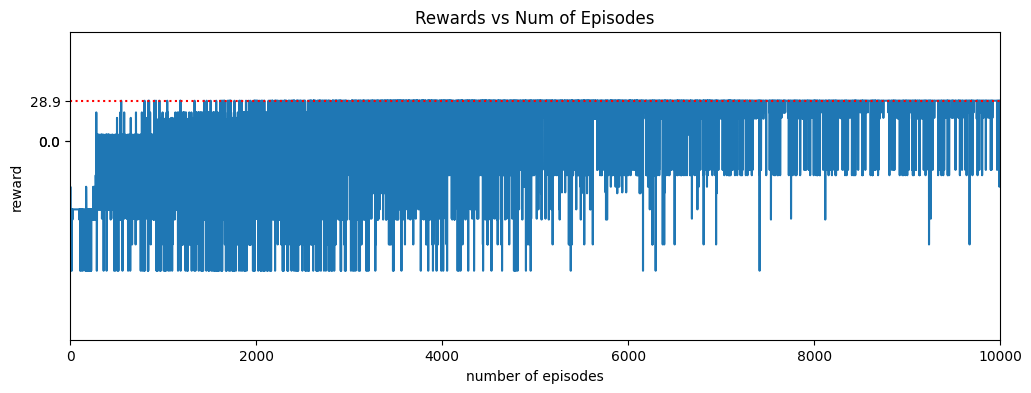

In [ ]:
plot_dynamics(fack_rewards)

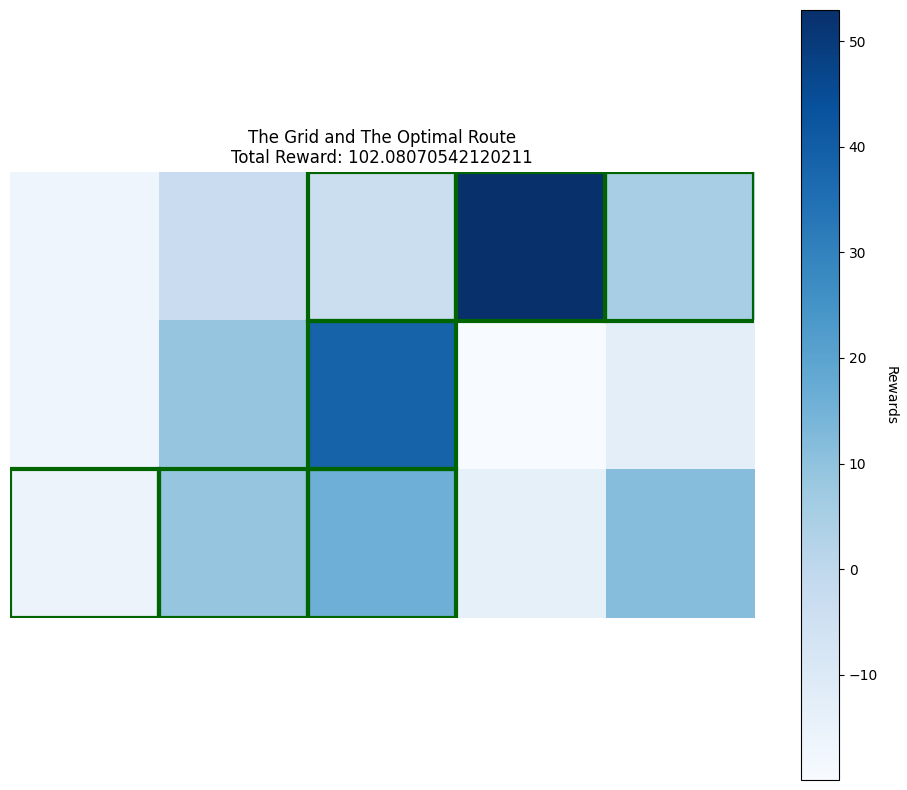

In [ ]:
plot_optimal_road(M, optimal_road= fack_road, optimal_value= max_road_reward, show_values= False, color = 'darkgreen')